# Problem

**State space.**
The states are encoded as integers
$$\mathcal{X} = {0,1,\dots,8} $$
corresponding to the grid in row-major order (top-left corner to bottom-right corner).
- State $8$ is the terminal goal state and is absorbing.
- State $5$ is the pit state and is absorbing.
- State $4$ is a wall.


**Action space.**
Actions are represented as integers

$$ \mathcal{A} = {0,1,2,3} $$

where $0 =$ Up, $1 =$ Down, $2 =$ Left, $3 =$ Right.

**Transition dynamics.**
Transitions are deterministic. For any state $x$ and action $a$, the state index is first mapped to its grid coordinates $(r,c)$, the action moves the agent one step (unless this would leave the grid), and the result is mapped back to a state index. The goal state $8$ always transitions to itself.
The transition matrix $P$ has shape $(|\mathcal{X}||\mathcal{A}|) \times |\mathcal{X}| = 36 \times 9$, where each row corresponds to a pair $(x,a)$ and contains a one-hot vector indicating the unique next state:

$$P[(x,a),x'] = 1 \quad \text{iff } x' = \text{next\_state}(x,a)$$

and $0$ otherwise.

**Reward model.**
- $r(x,a) = 1$ if x is a goal state.
- $r(x,a) = -1$ if x is the pit state.
- $r(x,a) = -0.01$ otherwise.

**Initial state.**
The initial state is fixed as $x_0 = 0$.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
# Add project root to the Python path
sys.path.append(str(PROJECT_ROOT))

from fogas import FOGASSolver, FOGASOracleSolver, FOGASHyperOptimizer, FOGASEvaluator, PolicySolver, EnvDataCollector

# Tabular Features

## Definition

### Description

**Feature Map**

We use a tabular one-hot feature representation over state–action pairs.
Each feature corresponds to a unique \((x,a)\) combination.

The feature map is defined as:
$$
\phi(x,a) \in \mathbb{R}^{36}
$$
with the ordering
$$
(x,a) \;\longrightarrow\; e_{\,x \cdot |\mathcal{A}| + a}
\quad |\mathcal{A}| = 4
$$

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega.
$$

The weight vector $\omega \in \mathbb{R}^{36}$ is defined as:
$$
\omega_i =
\begin{cases}
1 & \text{if } i \in \{8\cdot 4,\, 8\cdot 4 + 1,\, 8\cdot 4 + 2,\, 8\cdot 4 + 3\}, \\
-1 & \text{if } i \in \{5\cdot 4,\, 5\cdot 4 + 1,\, 5\cdot 4 + 2,\, 5\cdot 4 + 3\}, \\
-0.01 & \text{otherwise}.
\end{cases}
$$

**Transition Weights**

For each $x' \in \mathcal{X}$,
$$
\psi(x')_i =
\begin{cases}
1 & \text{if } i = 4x + a \text{ and } x' = \text{next\_state}(x,a), \\
0 & \text{otherwise}.
\end{cases}
$$

Equivalently, stacking $\psi(x')$ for all $x'$ recovers the tabular
transition matrix
$$
P \in \mathbb{R}^{36 \times 9}
$$
where each row $(x,a)$ contains a single 1 at the column corresponding
to $\text{next\_state}(x,a)$.

The terminal goal state $x = 8$ and pit state $x = 5$ is absorbing, so for all actions $a$,
$$
\text{next\_state}(8,a) = 8 \; \; \; \text{next\_state}(5,a) = 5
$$
And the state 4 is a wall.


## Testing

In [2]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state
dataset_path = "/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/3grid_wall.csv" # path where to download the dataset

goal = 8   # absorbing terminal state
pit = 5   # absorbing terminal state

def phi(x, a):
    vec = np.zeros(N * A)
    vec[x * A + a] = 1.0
    return vec

step_cost = -0.01
goal_reward = 1.0
pit_reward  = -1.0

omega = np.full(N * A, step_cost)

# terminals: you can either keep step cost or override; usually override
omega[goal * A : goal * A + A] = goal_reward
omega[pit  * A : pit  * A + A] = pit_reward


# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

wall = 4

def next_state(s, a):

    # absorbing terminals
    if s == goal or s == pit:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r-1), c
    elif a == 1:    # Down
        r2, c2 = min(2, r+1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c-1)
    elif a == 3:    # Right
        r2, c2 = r, min(2, c+1)

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp == wall:
        return s

    return sp

def psi(xp):
    v = np.zeros(N * A)
    for x in states:
        for a in actions:
            if next_state(x, a) == xp:
                v[x * A + a] = 1.0
    return v

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, psi=psi)

### Oracle

In [3]:
solver = FOGASOracleSolver(mdp=mdp, cov_matrix="identity", print_params=True, T=600)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      9255128.526390366
T (iterations):                600   (overridden → 600)

FOGAS Hyperparameters
---------------------
alpha:                        0.001133
rho:                            5.820702
eta:                            0.000022
D_theta:                    18.973666
beta (ridge):             0.000046
D_pi (derived):           12.897881





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = 0.0542
Order: ('eta', 'rho', 'alpha')

Optimizing eta
[After eta*] alpha=1.1330e-03, rho=1.0000e-02, eta=1.8244e-02 | metric = -0.2871

Optimizing rho
[After rho*] alpha=1.1330e-03, rho=1.0000e-03, eta=1.8244e-02 | metric = -0.2872

Optimizing alpha
[After alpha*] alpha=1.4599e-01, rho=1.0000e-03, eta=1.8244e-02 | metric = -0.6527


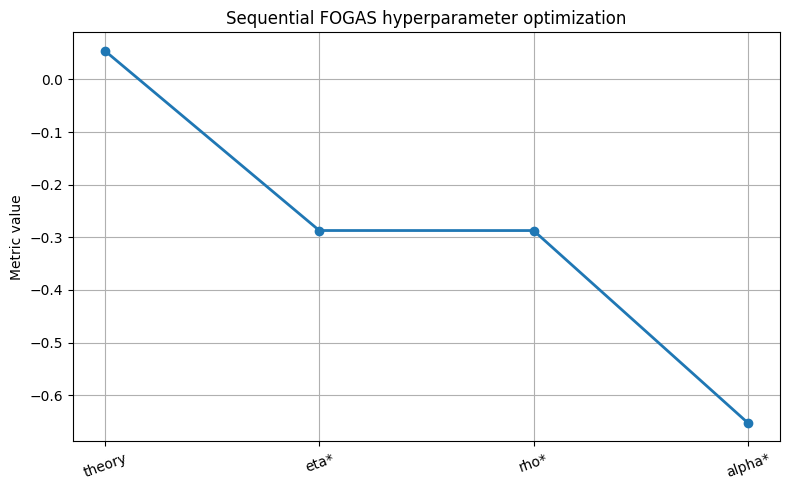

In [4]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [5]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS:   0%|          | 0/600 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 600/600 [00:00<00:00, 3551.08it/s]


========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 5.085585e-11
||Q^π - Q*||_2 = 7.927821e-11




In [6]:
evaluator.print_policy()

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 1.00  π(a=3|s=1) = 0.00  --> best action: 2
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.00  π(a=2|s=2) = 1.00  π(a=3|s=2) = 0.00  --> best action: 2
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 1.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 1
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0



### Dataset Collection

In [25]:
collector = EnvDataCollector(mdp=mdp, env_name="3grid_wall", max_steps=100)
collector.collect_dataset(n_steps=200, save_path="/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/3grid_wall.csv", verbose=True)

✅ Dataset saved to: /home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/3grid_wall.csv
   Total transitions: 200


,episode,step,state,action,reward,next_state
0,0,0,0,0,-0.01,0
1,0,1,0,1,-0.01,3
2,0,2,3,1,-0.01,6
3,0,3,6,2,-0.01,6
4,0,4,6,2,-0.01,6
...,...,...,...,...,...,...
195,11,7,6,2,-0.01,6
196,11,8,6,3,-0.01,7
197,11,9,7,2,-0.01,6
198,11,10,6,0,-0.01,3


### Empirical

In [33]:
solver_e = FOGASSolver(mdp=mdp, print_params=True, csv_path=dataset_path, T=1000)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           200
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      185.10257052780736
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000878
rho:                            1334.101842
eta:                            0.000017
D_theta:                    18.973666
beta (ridge):             0.000028
D_pi (derived):           16.651092




Trying same optimal hyperparameters found for the oracle.

In [34]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True, print_policies=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 0
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 0
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 0
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 0
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 0
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0


Iteration 101
  State 0: π(a=0|

Try again first eta, end alpha


=== FOGAS Hyperparameter Optimization ===
[Theory] metric = 0.0723
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
alpha=0.001, metric=0.0719659165283646
alpha=0.004135185542000139, metric=0.06419876832613261
alpha=0.01709975946676697, metric=0.049033788803023046
alpha=0.07071067811865475, metric=0.05582625069138758
alpha=0.2924017738212867, metric=0.09152618393908973
alpha=1.2091355875609793, metric=0.09665860351752906
alpha=5.000000000000001, metric=0.009046123075977405
Refinement: from 1.2091355875609793 to 5.000000000000001
Random 1: alpha=1.692, metric=-0.1912
Random 2: alpha=2.77, metric=-0.1915
Random 3: alpha=2.19, metric=-0.2077
Random 4: alpha=2.508, metric=-0.0430
Random 5: alpha=4.336, metric=0.4069
Random 6: alpha=3.183, metric=-0.0432
Random 7: alpha=1.75, metric=-0.0430
Random 8: alpha=4.769, metric=0.4076
Random 9: alpha=2.992, metric=0.0980
Random 10: alpha=1.3, metric=0.0105
[After alpha*] alpha=2.1899e+00, rho=1.3341e+03, eta=1.6905e-05 | metric = -0.2077

Optimizi

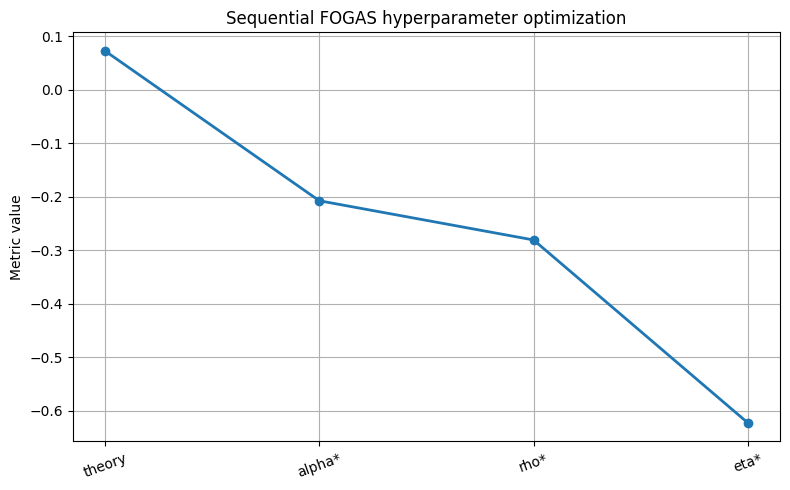

In [ ]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=7,
    print_main=True, 
    print_search=True,
    num_runs=1,
    random_candidates=10,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [ ]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS: 100%|██████████| 1000/1000 [00:18<00:00, 54.51it/s]


========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 2.150111e+01
||Q^π - Q*||_2 = 3.537687e+01



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 0.652661
J(π_FOGAS) = 0.622834
Gap (J* − J) = 2.982665e-02




In [37]:
evaluator_e.print_policy()

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.07  π(a=1|s=1) = 0.03  π(a=2|s=1) = 0.00  π(a=3|s=1) = 0.90  --> best action: 3
  State 2: π(a=0|s=2) = 0.07  π(a=1|s=2) = 0.84  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.08  --> best action: 1
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 0.98  π(a=2|s=3) = 0.01  π(a=3|s=3) = 0.01  --> best action: 1
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.11  π(a=2|s=6) = 0.09  π(a=3|s=6) = 0.80  --> best action: 3
  State 7: π(a=0|s=7) = 0.08  π(a=1|s=7) = 0.09  π(a=2|s=7) = 0.00  π(a=3|s=7) = 0.83  --> best action: 3
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0



It converged after an optimization trying all type of permutation between the three parameters relative to the order. Also heuristically choosing lower bounds to search and the most important thing: (INCREASING THE T FROM 200 TO 1000) but keeping $n =200$ that is much faster.

# Funky Features

## Definition

## Testing

In [ ]:
# -----------------------------
# Problem definition
# -----------------------------
states = np.arange(9)
actions = np.arange(4)
N = len(states)
A = len(actions)
gamma = 0.9

x_0 = 0
dataset_path = "/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/3grid_wall.csv"

goal = 8   # absorbing terminal state
pit  = 5   # absorbing terminal state
wall = 4   # wall cell

step_cost   = -0.01
goal_reward = 1.0
pit_reward  = -1.0

# -----------------------------
# Helpers: state index <-> (row, col)
# -----------------------------
def to_rc(s):  return divmod(int(s), 3)
def to_s(r,c): return int(r)*3 + int(c)

# -----------------------------
# Deterministic dynamics
# -----------------------------
def next_state(s, a):
    s = int(s); a = int(a)

    # absorbing terminals
    if s == goal or s == pit:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r-1), c
    elif a == 1:    # Down
        r2, c2 = min(2, r+1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c-1)
    elif a == 3:    # Right
        r2, c2 = r, min(2, c+1)
    else:
        raise ValueError("Invalid action")

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp == wall:
        return s

    return sp

# -----------------------------
# Build explicit transition matrix P: shape (N*A, N)
# Row corresponds to (x,a) in row-major order: idx = x*A + a
# -----------------------------
P = np.zeros((N * A, N))
for x in states:
    for a in actions:
        idx = int(x) * A + int(a)
        xp = next_state(x, a)
        P[idx, xp] = 1.0

# -----------------------------
# action features: [1, dr, dc] in R^3
# state features: row_onehot ⊗ col_onehot in R^9 (exact state one-hot)
# phi(x,a) = kron(phi_action(a), phi_state(x)) in R^(3*9)=R^27
# -----------------------------
d_state  = 9
d_action = 3
d_feat   = d_state * d_action  # 27

def phi_state(x):
    r, c = to_rc(x)
    row = np.zeros(3); row[r] = 1.0
    col = np.zeros(3); col[c] = 1.0
    return np.kron(row, col)  # R^9

def phi_action(a):
    a = int(a)
    if a == 0:   dr, dc = -1.0,  0.0  # Up
    elif a == 1: dr, dc =  1.0,  0.0  # Down
    elif a == 2: dr, dc =  0.0, -1.0  # Left
    elif a == 3: dr, dc =  0.0,  1.0  # Right
    else:
        raise ValueError("Invalid action")
    return np.array([1.0, dr, dc])  # R^3

def phi(x, a):
    return np.kron(phi_action(a), phi_state(x))  # R^27

# -----------------------------
# Exact omega for state-only reward:
# r(x,a) = r_state(x) for all actions
# Put r_state into the "bias block" omega[0:9], rest zeros.
# -----------------------------
r_state = np.full(N, step_cost)
r_state[goal] = goal_reward
r_state[pit]  = pit_reward

omega = np.zeros(d_feat)
omega[:d_state] = r_state  # exact

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P)

### Oracle

In [46]:
solver = FOGASOracleSolver(mdp=mdp, cov_matrix="identity", print_params=True, T=1500)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            27
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      18510257.052780736
T (iterations):                1500   (overridden → 1500)

FOGAS Hyperparameters
---------------------
alpha:                        0.000585
rho:                            4.559519
eta:                            0.000013
D_theta:                    16.431677
beta (ridge):             0.000049
D_pi (derived):           14.420269





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = 0.0639
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.8044e+00, rho=1.0000e-02, eta=1.3013e-05 | metric = -0.6401

Optimizing rho
[After rho*] alpha=4.8044e+00, rho=1.2126e+00, eta=1.3013e-05 | metric = -0.6527

Optimizing eta
[After eta*] alpha=4.8044e+00, rho=1.2126e+00, eta=4.6560e-05 | metric = -0.6527


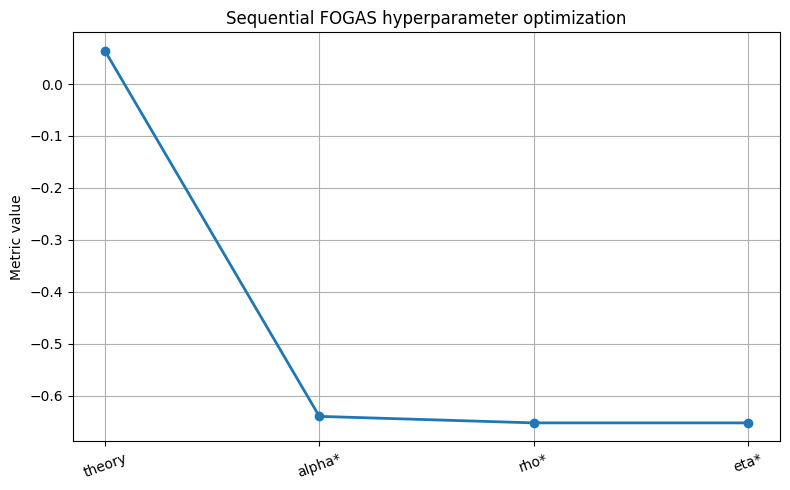

In [47]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [50]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:03<00:00, 471.98it/s]


========== VALUE FUNCTION COMPARISON ==========


Norm diagnostics:
||V^π - V*||_2 = 1.998358e+01
||Q^π - Q*||_2 = 3.587660e+01




In [49]:
evaluator.print_policy()

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 1.00  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.00  --> best action: 1
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 1.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 1
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0



### Empirical

In [7]:
solver_e = FOGASSolver(mdp=mdp, print_params=True, csv_path=dataset_path, T=1000)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           200
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            27
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      370.2051410556148
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000717
rho:                            1000.576381
eta:                            0.000016
D_theta:                    16.431677
beta (ridge):             0.000074
D_pi (derived):           11.774100




In [8]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

NameError: name 'alpha_star' is not defined

In [9]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=10,
    print_main=True, 
    num_runs=1,
    order=("alpha", "rho", "eta")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

KeyboardInterrupt: 

In [10]:
solver_e.run(tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1000 [00:00<?, ?it/s]

FOGAS:   4%|▍         | 42/1000 [00:08<03:12,  4.97it/s]


KeyboardInterrupt: 

In [ ]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [ ]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()